In [1]:
from f_drosophila_infer import *
from f_train import *
from f_data_prep import *

In [2]:
def infer_quad_train_test(X, y, gene_comp=[], kf=10, hp_l=0.1):
    quad = np.copy(X)
    kfold = KFold(n_splits=kf, shuffle=False, random_state=1)
    
    error_list=[]
    if len(gene_comp) == 0:
        for i in range(X.shape[1]-1):
            for j in range(i+1, X.shape[1]):
                quad = np.hstack((quad, (X[:,i]*X[:,j])[:,None]))
    else:
        for i in range(len(comp_ind)-1):
            for j in range(i+1, len(comp_ind)):
                quad = np.hstack((quad, (X[:,comp_ind[i]]*X[:,comp_ind[j]])[:,None]))
            
    for (tr_ind, te_ind) in (kfold.split(y)):
        X_tr, quad_tr, y_tr = X[tr_ind], quad[tr_ind], y[tr_ind]
        X_te, quad_te, y_te = X[te_ind], quad[te_ind], y[te_ind]
        
        if y.shape[1] == len(gene_comp):
            X_init = np.copy(X_te[:, comp_ind])
        else:
            X_init = np.copy(X_te)
            
        y_actual = X_init + y_te   
        y_actual_sum_sq = np.sum(np.abs(y_actual)**2, axis=0)
        
        w, sigma, bias = infer_drosophila_quad(quad_tr, y_tr, power=3, l=hp_l)
        y_pred = X_init + odd_power(bias+quad_te.dot(w), 3) + sigma*npr.normal(size=(1,w.shape[1]))
        error = (np.sum(np.abs(y_pred - y_actual)**2, axis=0)/y_actual_sum_sq)**(1/2)
        error_list.append(error)
    return np.mean(error_list, axis=0), np.std(error_list, axis=0)

In [3]:
data_all = np.loadtxt('../data_complete.txt')
# data_all = data_all - np.median(data_all, axis=0)
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
comp_init = np.vstack([comp_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

In [4]:
all_init, comp_diff_99 = shuffle(all_init, np.copy(comp_diff))    #(99,27) to 27
comp_init, comp_diff_27 = shuffle(comp_init, np.copy(comp_diff))  #(27,27) to 27

In [5]:
start = timeit.default_timer()
all_mean_0d1, all_std_0d1 = infer_quad_train_test(all_init, comp_diff_99, gene_comp=comp_ind, kf=10, hp_l=0.1)
all_mean_1, all_std_1 = infer_quad_train_test(all_init, comp_diff_99, gene_comp=comp_ind, kf=10, hp_l=1)
comp_mean_0d1, comp_std_0d1 = infer_quad_train_test(comp_init, comp_diff_27, gene_comp=[], kf=10, hp_l=0.1)
comp_mean_1, comp_std_1 = infer_quad_train_test(comp_init, comp_diff_27, gene_comp=[], kf=10, hp_l=1)
end = timeit.default_timer()

print('Time: %s' % (end-start))

Time: 26675.029026381206


In [6]:
print('Time: %s' % ((end-start)/60/60))

Time: 7.409730285105891


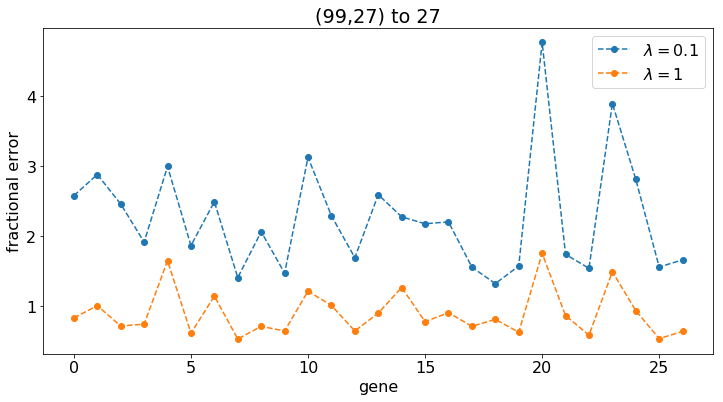

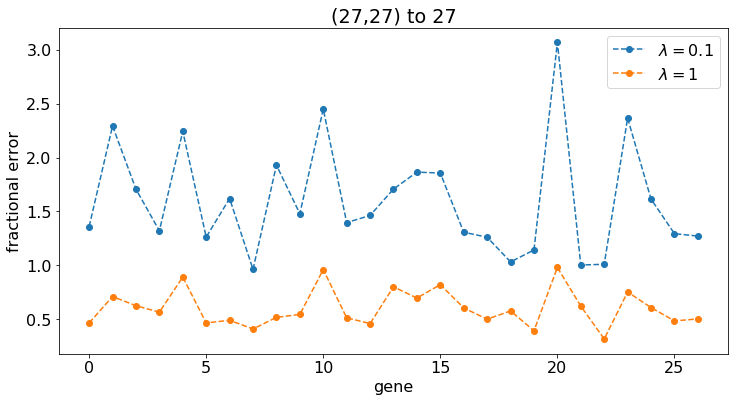

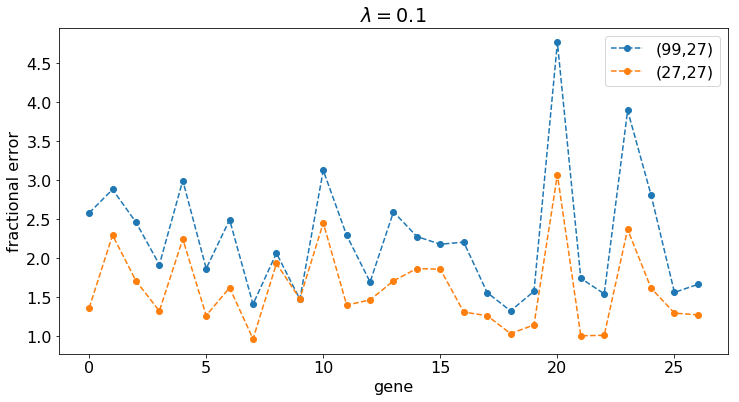

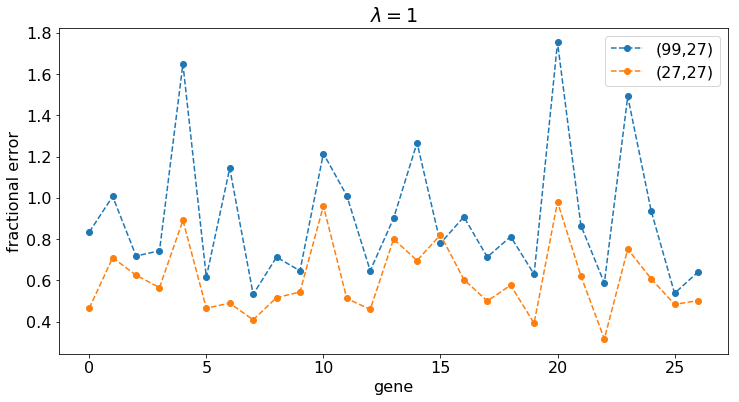

In [7]:
plt.figure(figsize=(12,6))
plt.plot(range(len(all_mean_0d1)), all_mean_0d1, 'o--', label='$\lambda=0.1$')
plt.plot(range(len(all_mean_1)), all_mean_1, 'o--', label='$\lambda=1$')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.title('(99,27) to 27')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(range(len(comp_mean_0d1)), comp_mean_0d1, 'o--', label='$\lambda=0.1$')
plt.plot(range(len(comp_mean_1)), comp_mean_1, 'o--', label='$\lambda=1$')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.title('(27,27) to 27')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(range(len(comp_ind)), all_mean_0d1, 'o--', label='(99,27)')
plt.plot(range(len(comp_ind)), comp_mean_0d1, 'o--', label='(27,27)')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.title('$\lambda=0.1$')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(range(len(comp_ind)), all_mean_1, 'o--', label='(99,27)')
plt.plot(range(len(comp_ind)), comp_mean_1, 'o--', label='(27,27)')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.title('$\lambda=1$')
plt.legend(loc='best')
plt.show()